# Solve 1D advection (wave propagation) problem

$$
\frac{\partial u}{\partial t} + c(x) \frac{\partial u}{\partial x} =0
$$

on the finite domain $x\in \lbrace{0,L\rbrace}$ with boundary conditions

(Dirichlet on left side)
$$
u(0) = a_0 \sin(\omega t),\ x=0
$$

(Neumann on right side)
$$
u_x(L) = 0,\ x=L
$$


In [59]:
import time
import numpy as np
import dedalus.public as de
from dedalus.tools  import post

from dedalus.extras.plot_tools import quad_mesh, pad_limits


import logging
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

In [60]:
%matplotlib notebook


In [70]:
# Constants

# Phase speed
# c = 1.1

c0 = 2.
c1 = 1.


a0 = 1. # Amplitude

L = 120000.0
nx = 256

omega = 2*np.pi/(12*3600.)


In [71]:
# CReate the domain

x = de.Chebyshev('x',nx,interval=[0.,L])
domain = de.Domain([x],grid_dtype='float')


In [72]:
# Create the problem
problem = de.IVP(domain, variables=['u','ux'])
problem.parameters['a0'] = a0
problem.parameters['omega'] = omega

# Constant c
#problem.parameters['c'] = c

# Varying c
problem.parameters['c1'] = c1
problem.parameters['c0'] = c0
xg, = domain.grids(scales=1)
ncc = domain.new_field(name = 'c')
ncc['g'] = c1 - (c0-c1)/L * xg
problem.parameters['c'] = ncc

problem.add_equation('dt(u) + c* dx(u) = 0')
problem.add_equation("ux - dx(u) = 0")


# Add the boundary conditions
problem.add_bc('left(u) = a0*sin(omega*t)')
problem.add_bc('right(ux) = 0')

In [73]:
solver = problem.build_solver(de.timesteppers.RK443)

solver.stop_sim_time = 2*86400.0
solver.stop_wall_time = 1000.
solver.stop_iteration = np.inf
dt = 30.

# Store data for final plot
# Initial conditions
z = domain.grid(0)
u = solver.state['u']

u.set_scales(1, keep_data=True)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 100 == 0:
        logger.info("Time step {}".format(solver.iteration))
        u.set_scales(1, keep_data=True)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
end_time = time.time()
# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)
logger.info('Average timestep: %f' %(solver.sim_time/solver.iteration))

2020-12-04 12:11:51,819 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+01/s
2020-12-04 12:11:51,941 __main__ 0/1 INFO :: Time step 100
2020-12-04 12:11:52,044 __main__ 0/1 INFO :: Time step 200
2020-12-04 12:11:52,147 __main__ 0/1 INFO :: Time step 300
2020-12-04 12:11:52,252 __main__ 0/1 INFO :: Time step 400
2020-12-04 12:11:52,355 __main__ 0/1 INFO :: Time step 500
2020-12-04 12:11:52,460 __main__ 0/1 INFO :: Time step 600
2020-12-04 12:11:52,567 __main__ 0/1 INFO :: Time step 700
2020-12-04 12:11:52,672 __main__ 0/1 INFO :: Time step 800
2020-12-04 12:11:52,778 __main__ 0/1 INFO :: Time step 900
2020-12-04 12:11:52,885 __main__ 0/1 INFO :: Time step 1000
2020-12-04 12:11:52,992 __main__ 0/1 INFO :: Time step 1100
2020-12-04 12:11:53,106 __main__ 0/1 INFO :: Time step 1200
2020-12-04 12:11:53,213 __main__ 0/1 INFO :: Time step 1300
2020-12-04 12:11:53,316 __main__ 0/1 INFO :: Time step 1400
2020-12-04 12:11:53,423 __main__ 0/1 INFO :: Ti

In [74]:
u_array = np.array(u_list)
t_array = np.array(t_list)
zmesh, tmesh = quad_mesh(x=z, y=t_array)

<IPython.core.display.Javascript object>


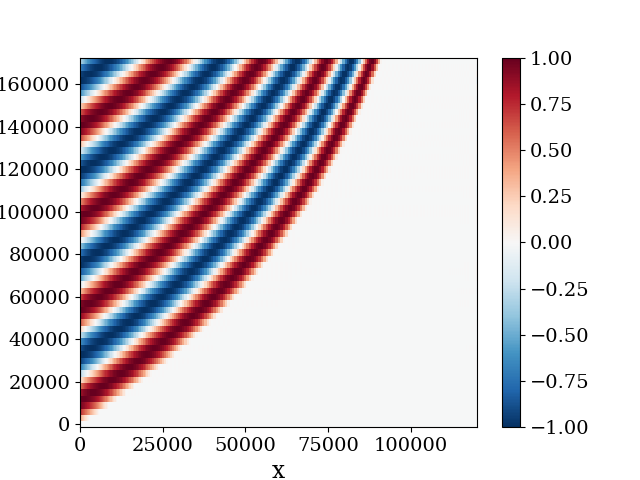

In [75]:
plt.figure()
plt.pcolormesh(zmesh, tmesh, u_array, cmap='RdBu_r')
plt.axis(pad_limits(zmesh, tmesh))
plt.colorbar()
plt.ylabel('t')
plt.xlabel('x')

plt.show()

<IPython.core.display.Javascript object>


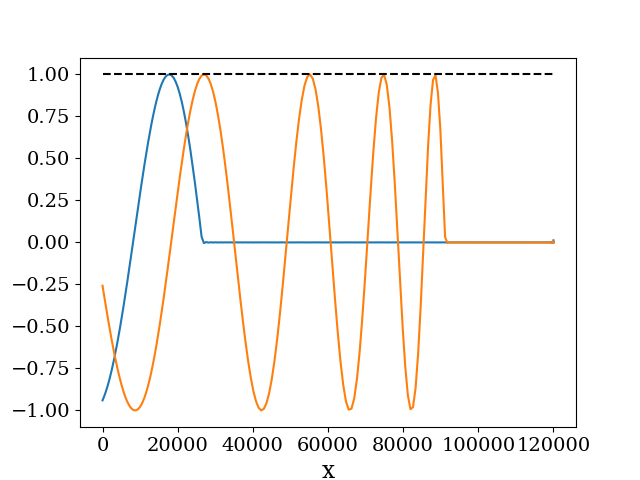

Text(0.5, 0, 'x')

In [76]:
plt.figure()
plt.plot(z,u_array[10,:])
plt.plot(z, u_array[-1,:])
plt.plot([z[0],z[-1]],[1.,1.],'k--')
plt.xlabel('x')
